# Astronomer - ML Intern Assignment
January 12, 2022 <br>
Amir Zahreddine

### In this project, we will dive into the preprocessing and analysis of indident tickets submitted to the Astronomer github repository.
## Table of Contents <a class="anchor" id="TOC"></a>
* [Part 1: Pulling the Data](#1)
* [Part 2: Preprocessing the Data](#2)
* [Part 3: Descriptive Analytics](#3)
* >[Part 3a: Volume of Tickets Over Time](#3a)
* >[Part 3b: Isolating the Number of Unique Visitors](#3b)
* >[Part 3c: Length of Time for a Ticket to Close](#3c)
* >[Part 3d: Removing Outliers from Numerical Columns with Z-Score Method](#3d)
* [Part 4: Machine Learning (Regression to Predict Ticket Resolution Time)](#4)

# Part 1: Pulling the Data <a class="anchor" id="1"></a>

[return to TOC](#TOC)

In [200]:
'''
Here are some preliminary imports. We'll need more.
Feel free to install and import any packages you'd like.
'''
import requests
import os
import json
import numpy as np
import pandas as pd

# Additional Libraries
import config #to pull API secret key
from matplotlib import pyplot as plt
import datetime as dt
import seaborn as sns

# x axis ticks
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

In [201]:
'''
Let's retrieve all issues in the Apache Airflow OSS project using the github api. 
Insert your username below (in two places).

You should end up with about 20k issues, including ones that date back to 2015 when the project was created.
'''
def get_issues_from_api():
    session = requests.Session()
    url = "https://api.github.com/repos/apache/airflow/issues?state=all"
    response = session.get(
        url,
        auth=(
            "AmirZahre", # your github username
            config.api_secret
        ),
    )
    yield response.json()

    page=2
    while 'next' in response.links:
        response = session.get(
            url,
            auth=(
                "AmirZahre", # your github username
                config.api_secret
            ),
            params={"page": page}
        )
        page += 1
        yield response.json()
        

def get_all_issues(cache_path="airflow_issues.feather"):
    if os.path.exists(cache_path):
        print("retrieving issues from cache")
        df = pd.read_feather(cache_path)
    else:
        print("retrieving issues from API")
        df_shards = []
        for i, page in enumerate(get_issues_from_api()):
            print(f"retrieving page {i}")
            if not page:
                print(f"No issues found on page {i}: {page}")
                continue
            page_df = pd.DataFrame(page)
            df_shards.append(page_df)
        df = pd.concat(df_shards).reset_index()
        print(f"Saving results to {cache_path}")
        df.to_feather(cache_path)
    return df


In [202]:
df = get_all_issues()

retrieving issues from cache


In [203]:
pd.set_option('display.max_columns',None)
df.head()

,index,url,repository_url,labels_url,comments_url,events_url,html_url,id,node_id,number,title,user,labels,state,locked,assignee,assignees,milestone,comments,created_at,updated_at,closed_at,author_association,active_lock_reason,draft,pull_request,body,reactions,timeline_url,performed_via_github_app
0,0,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://github.com/apache/airflow/pull/20767,1096939225,PR_kwDOAgUK284wsGiW,20767,Rename amazon EMR hook name,{'avatar_url': 'https://avatars.githubusercont...,"[{'color': 'f89500', 'default': False, 'descri...",closed,False,None,[],None,3,2022-01-08T14:15:31Z,2022-01-08T15:26:11Z,2022-01-08T15:26:09Z,CONTRIBUTOR,None,False,{'diff_url': 'https://github.com/apache/airflo...,Renamed emr hook from Elastic MapReduce to Ama...,"{'+1': 0, '-1': 0, 'confused': 0, 'eyes': 0, '...",https://api.github.com/repos/apache/airflow/is...,None
1,1,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://github.com/apache/airflow/issues/20766,1096938561,I_kwDOAgUK285BYfRB,20766,Status of testing Providers that were prepared...,{'avatar_url': 'https://avatars.githubusercont...,"[{'color': '5319e7', 'default': False, 'descri...",open,False,None,[],None,0,2022-01-08T14:12:48Z,2022-01-08T14:12:48Z,None,MEMBER,None,None,None,### Body\n\nI have a kind request for all the ...,"{'+1': 0, '-1': 0, 'confused': 0, 'eyes': 0, '...",https://api.github.com/repos/apache/airflow/is...,None
2,2,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://github.com/apache/airflow/pull/20765,1096903757,PR_kwDOAgUK284wsBH7,20765,Add documentation for an ad-hoc release of 2 p...,{'avatar_url': 'https://avatars.githubusercont...,"[{'color': 'd4c5f9', 'default': False, 'descri...",closed,False,None,[],None,1,2022-01-08T11:24:41Z,2022-01-08T13:59:11Z,2022-01-08T13:59:11Z,MEMBER,None,False,{'diff_url': 'https://github.com/apache/airflo...,<!--\r\nThank you for contributing! Please mak...,"{'+1': 0, '-1': 0, 'confused': 0, 'eyes': 0, '...",https://api.github.com/repos/apache/airflow/is...,None
3,3,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://github.com/apache/airflow/pull/20764,1096847036,PR_kwDOAgUK284wr3Zo,20764,Update metric name in documentation,{'avatar_url': 'https://avatars.githubusercont...,"[{'color': '0030b5', 'default': False, 'descri...",open,False,None,[],None,1,2022-01-08T06:15:11Z,2022-01-08T15:21:56Z,None,CONTRIBUTOR,None,False,{'diff_url': 'https://github.com/apache/airflo...,<!--\r\nThank you for contributing! Please mak...,"{'+1': 0, '-1': 0, 'confused': 0, 'eyes': 0, '...",https://api.github.com/repos/apache/airflow/is...,None
4,4,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://api.github.com/repos/apache/airflow/is...,https://github.com/apache/airflow/pull/20763,1096844110,PR_kwDOAgUK284wr25c,20763,[WIP] Verify enough resources for breeze,{'avatar_url': 'https://avatars.githubusercont...,"[{'color': 'ededed', 'default': False, 'descri...",open,False,None,[],None,0,2022-01-08T05:57:03Z,2022-01-08T15:35:18Z,None,CONTRIBUTOR,None,False,{'diff_url': 'https://github.com/apache/airflo.

# Part 2: Preprocessing the Data <a class="anchor" id="2"></a>

[return to TOC](#TOC)

In [204]:
'''
For xlabel changes in a few graphs below there the x-axis is the month
'''
def getMonthName(month_number):
    testdate=dt.date(2010,int(month_number),1)
    return testdate.strftime('%b')


'''
For removing outliers in a few tables below
'''
# Removing outliers using the below formula
import scipy

# pulled from https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-a-pandas-dataframe by KeyMaker00
def drop_numerical_outliers(df1):
    # Constrains will contain `True` or `False` depending on if it is a value below the threshold.
    constrains = df1.select_dtypes(include=[np.number]) \
        .apply(lambda x: np.abs(scipy.stats.zscore(x)) < 3) \
        .all(axis=1)
    # Drop (inplace) values set to be rejected
    df1.drop(df1.index[~constrains], inplace=True)

In [205]:
'''
There are lots of fields in the data. 
We will preprocess the data, engineer some features, and keep only the promising features.
'''
df.columns

Index(['index', 'url', 'repository_url', 'labels_url', 'comments_url',
       'events_url', 'html_url', 'id', 'node_id', 'number', 'title', 'user',
       'labels', 'state', 'locked', 'assignee', 'assignees', 'milestone',
       'comments', 'created_at', 'updated_at', 'closed_at',
       'author_association', 'active_lock_reason', 'draft', 'pull_request',
       'body', 'reactions', 'timeline_url', 'performed_via_github_app'],
      dtype='object')

In [206]:
df.author_association.value_counts()

CONTRIBUTOR     9022
MEMBER          7047
NONE            3589
COLLABORATOR      10
Name: author_association, dtype: int64

In [207]:
df = df.drop(columns=['index', 'url', 'repository_url', 'labels_url', 'comments_url',
                      'events_url', 'html_url', 'performed_via_github_app', 'locked',
                      'active_lock_reason', 'assignees', 'milestone'])

# Processing timestamps
df['created_at'] = pd.to_datetime(df['created_at'], format="%Y/%m/%d")
df['closed_at'] = pd.to_datetime(df['closed_at'], format="%Y/%m/%d")

# Binarizing some features
df["has_pull_request"] = df.pull_request.apply(lambda x: True if x is not None else False)
df["has_comment"] = df.comments.apply(lambda x: True if x > 0 else False)
df['has_assignee'] = df['assignee'].apply(lambda x: True if x is not None else False)


# Binarizing some more features
df["contributor"] = df.author_association.apply(lambda x: True if x == 'CONTRIBUTOR' else False)
df["member"] = df.author_association.apply(lambda x: True if x == 'MEMBER' else False)
df["collaborator"] = df.author_association.apply(lambda x: True if x == 'COLLABORATOR' else False)
df["not_a_member"] = df.author_association.apply(lambda x: True if x == 'NONE' else False)

# Extracting the lengths of text features `title` and `body`
df = df[df.body.notnull()]
df['length_of_title'] = df['title'].apply(lambda x: len(x))
df['length_of_body'] = df['body'].apply(lambda x: len(x))

# Removing issues created by bots
df['creator_user_login'] = df['user'].apply(lambda x: x.get('login'))
df = df[df['creator_user_login'] != 'dependabot[bot]']

In [208]:
# Parsing the `labels` to determine the number of labels and which of the popular labels are used for each issue
df['label_names'] = df['labels'].apply(lambda x: [str(i.get('name')) for i in x])
df['n_labels'] = df['label_names'].apply(lambda x: len(x))
not_labels = df.columns.to_list()

def label_column_to_true(row):
    for label in row.label_names:
        label = (
            label     
            .replace(":", "_")
            .replace(" ", "_")
            .replace("/", "_")
            .replace("'", "")
            .replace(".", "_")
            .replace("-", "_")
        )
        row[label] = 1
    return row


df_labels = df.apply(label_column_to_true, axis=1)
df_labels = df_labels.loc[:, ~df_labels.columns.isin(not_labels)]

# Labels that are used for at least 5% of issues
df_labels_keep = df_labels.T[(df_labels.isna().sum(axis=0) < len(df_labels)*0.95)].T
df_labels_keep.fillna(0, inplace=True)
df_labels_keep = df_labels_keep.astype("bool")
df_labels_keep = df_labels_keep.add_prefix('label_')
df = df.join(df_labels_keep)

In [209]:
# Parsing the issue creators to identify users who create issues frequently
df['creator_user_id'] = df['user'].apply(lambda x: x.get('id'))
creators = df.creator_user_id.value_counts()

# Issues created by top 0.05% issue creators
freq_creators = dict(df.creator_user_id.value_counts(normalize=True).loc[lambda x : x>0.0005]) 
df['frequent_issue_creator'] = df.creator_user_id.apply(lambda x: x in freq_creators.keys())

# Add and rearrange username and user ID
creator_user_login = df.pop('creator_user_login')
creator_user_id = df.pop('creator_user_id')
df.insert(2, 'creator_user_login', creator_user_login)
df.insert(3, 'creator_user_id', creator_user_id)

In [210]:
# We now have our list of features to study
features = [
    'title',
    'creator_user_login',
    'creator_user_id',
    'body',
    'created_at',
    'state',
    'closed_at',
    'frequent_issue_creator',
    'author_association', 
    'length_of_title', 
    'length_of_body',
    'has_assignee', 
    'has_pull_request', 
    'has_comment',
    'comments',
    'contributor',
    'member',
    'collaborator',
    'not_a_member',
    'n_labels'] + list(df_labels_keep.columns)

df.drop([c for c in df if c not in features], axis=1, inplace=True)



df["contributor"] = df.author_association.apply(lambda x: True if x == 'CONTRIBUTOR' else False)
df["member"] = df.author_association.apply(lambda x: True if x == 'MEMBER' else False)
df["collaborator"] = df.author_association.apply(lambda x: True if x == 'COLLABORATOR' else False)
df["not_a_member"] = df.author_association.apply(lambda x: True if x == 'NONE' else False)

## Additional Preprocessing #2

In [211]:
'''
Add column for year and month of created and closed dates.
'''

df.insert(loc=5, column='created_date',value=pd.to_datetime(df.created_at.dt.strftime('%Y-%m-%d')))
df.insert(loc=6, column='closed_date',value=pd.to_datetime(df.closed_at.dt.strftime('%Y-%m-%d')))


'''
Add column for length of time, in days, for a problem to be closed from the time it was opened
'''
df.insert(loc=7, column='time_to_close', value=df.closed_date - df.created_date) # create column
df.time_to_close = df.time_to_close.apply(lambda x: x.days) # convert column to day value only (omit HH:MM:SS)
df.time_to_close = df.time_to_close.apply(lambda x: 'Not Closed' if pd.isnull(x) else int(x)) # convert values to int, NaN if NaN

In [212]:
df['creator_user_id'] = df['creator_user_id'].astype(str)

# Part 3: Descriptive Analytics <a class="anchor" id="3"></a>

[return to TOC](#TOC)

Let's study the cleaned-up data to summarize their attributes and find interesting trends, if any. 

#### Questions to ask:
Level 1:
* Average time for a ticket to be completed (days from opened to closed)? **(can gauge the health of the community. if tickets are being answered/fixed quickly, that is a good sign)**
* When do the greatest number of tickets usually occur? Is there seasonality? **(can be used to potentially add more resources during 'high seasons')**
* Are there key players who answer the most tickets? **(can dig into their places of employment through their github profile)**
* Are incidents happening more or less frequently over time?
* Is the number of incidents acceptable or could it be lower?
* Ticket volume by specific issue (label?)
* First contact resolution - tickets closed with only one comment?

Level 2:
* Has there been an improvement of ticket response time over the years?
* Are there greater concentrations of speficic individuals submitting tickets?
* Is there a trend of companies submitting requests? **(if there are a lot of individuals from a single company with issues, Astronomer can look into reaching out for additional support)**
* Can we find clusters of incidents occuring during a specific time?
* Backlogs and predicted backlogs
* Number of unique users

Level 3:
* Can a trend be found for ticket open/close times? Do tickets with a greater number of labels see quicker response time, etc?

# Part 3a: Volume of Tickets Over Time <a class="anchor" id="3a"></a>

[return to TOC](#TOC)

Is there a trend pertaining to the number of tickets submitted? Have they been increasing, decreasing, or stagnant?

It's good to know how busy things are. Are there any obvious signs of seasonality? Are things becoming busier?

In [213]:
'''
Group the creation date of tickets by Year and Month. Count the number of tickets for each period.
'''

# Group tickets by Year > Month
monthly_tickets = (df.groupby([df.created_date.dt.year, df.created_date.dt.month])
           .size() # Get the count of values for each period
           .rename_axis(index=['year', 'month'],)
           .reset_index())

monthly_tickets.columns.values[2] = "number_of_tickets"
monthly_tickets

,year,month,number_of_tickets
0,2015,4,2
1,2015,6,96
2,2015,7,111
3,2015,8,129
4,2015,9,138
...,...,...,...
76,2021,9,584
77,2021,10,575
78,2021,11,473
79,2021,12,592


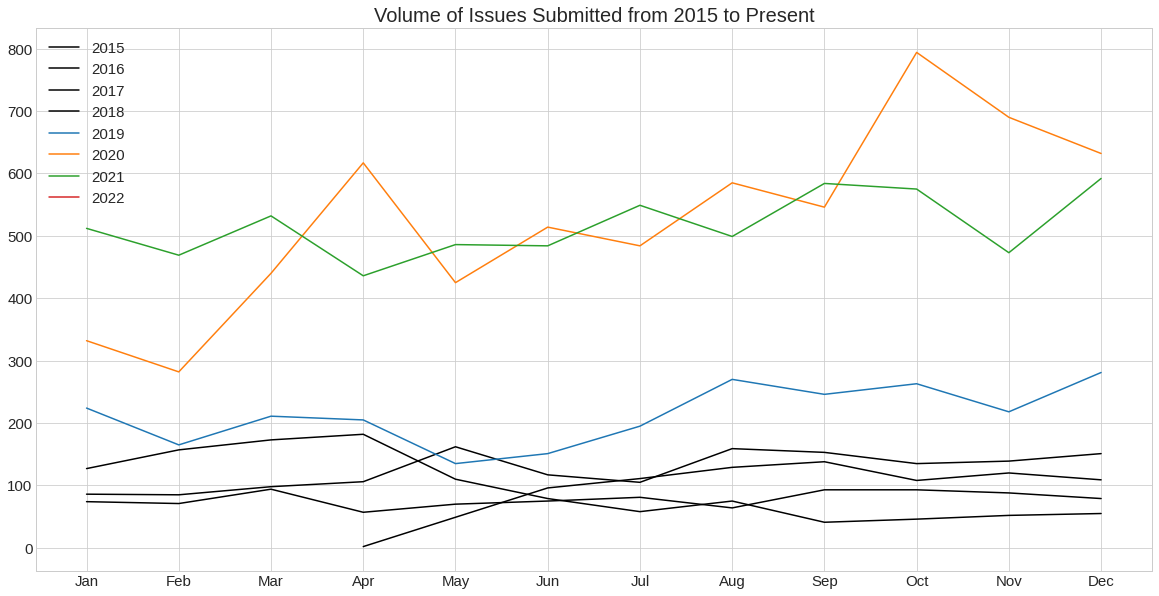

In [214]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))

# plotting for each year, by month
# years prior to, and including, 2019
years = [2015, 2016, 2017, 2018]
i = 0
for year in years:
    sub = monthly_tickets[monthly_tickets['year'] == year]
    ax.plot(sub['month'], sub['number_of_tickets'], label=year, c='black')
    i += 1

# years of 2019 to present    
years = [2019,2020, 2021, 2022]
i = 0
for year in years:
    sub = monthly_tickets[monthly_tickets['year'] == year]
    ax.plot(sub['month'], sub['number_of_tickets'], label=year)
    i += 1    

    
# x-axis ticks
# rename x-axis from month number to month name
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,p:getMonthName(x)))
ax.set_xticks(np.arange(1, 13, 1.0))  

# legend
ax.legend(loc="upper left")

plt.title('Volume of Issues Submitted from 2015 to Present', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.style.use('seaborn-whitegrid')     
plt.show()

* On a month to month basis, the volume of tickets hovered at around the same levels for the years 2015 to 2018.
* Beginning 2019, ticket volume begins to increase above historic levels.
* 2020 is where things begin to get interesting, as ticket volume begins to substantially increase.
* Overall, there is a substantial increase in volume for the entire periods of 2020 and 2021 vs. the years prior.

### How does the volume of tickets match with the number of unique visitors? Is it the same people just asking more tickets, or can this partially be attributed to a greater number of unique individuals experiencing issues?

# Part 3b: Isolating the Number of Unique Visitors <a class="anchor" id="3b"></a>

[return to TOC](#TOC)

Has there been an uptick of unique users? Are the tickets submitted by a regular group of individuals? 

Looking at this data can help us understand the growth of the repository as a place of knowledge for Apache Airflow.

In [215]:
'''
Reverse earlier code that set 'creator_user_id' to a string. 
We need to use the numbers themselves in order to organize them within a BST.
'''

df['creator_user_id'] = df['creator_user_id'].astype(int)

In [216]:
'''
Create a Binary Search Tree (BST).
The BST will be used to quickly and efficiently organize user ID's.
Starting from 2015 and moving towards the present, each user ID will be compared to the user ID's in the BST.
If the user ID exists, that user is **not** a unique submitter; however, if it does not exist, it's the user's first time submitting a ticket -- and therefore, they're unique.
Code pulled from https://qvault.io/python/binary-search-tree-in-python/ and https://qvault.io/python/binary-search-tree-in-python/
'''

class BSTNode:
    def __init__(self, val=None):
        self.left = None
        self.right = None
        self.val = val
        
    # Insert value into tree
    def insert(self, val):
        if not self.val:
            self.val = val
            return

        if self.val == val:
            return

        if val < self.val:
            if self.left:
                self.left.insert(val)
                return
            self.left = BSTNode(val)
            return

        if self.right:
            self.right.insert(val)
            return
        self.right = BSTNode(val)
    
    
    
    # Check if value exists in tree
    def exists(self, val):
        if self.val is None:
            return
        
        if val == self.val:
            return True

        if val < self.val:
            if self.left == None:
                return False
            return self.left.exists(val)

        if self.right == None:
            return False
        return self.right.exists(val)
    
# Print the tree in a horizontal-moving shape
def printTree(node, level=0):
    if node != None:
        printTree(node.left, level + 1)
        print(' ' * 4 * level + '->', node.val)
        printTree(node.right, level + 1)

In [217]:
'''
Cycle through each ID and add to the BST
If the ID exists, that will be a repeat visitor
If the ID does NOT exist, it is a unique visitor.
If it is a unique visitor, incriment +1 for the respective Month, Year
'''

# Reverse the df so that the earliest case is at the beginning
df_rev = df.iloc[::-1]

# Initialize the lists and the tree
unique_ID = []
unique_date = []
bst = BSTNode()

# For each row within the reversed df (beginning 2015)
for index, row in df_rev.iterrows():
    # If the submitter ID does NOT exist, it is assumed to be unique
    if bst.exists(row[1]) == False:
        # Therefore, append each of the tables unique_date and unique_ID with the creation date of the ticket and user ID, respectively
        unique_date.append(row[5].date())
        unique_ID.append(row[1])
    # Finally, insert the user ID into the BST so that it won't be double-counted as unique    
    bst.insert(row[1])


# Add the two lists from above into a DF
x = pd.Series(unique_date)
y = pd.Series(unique_ID)
headers = ['unique_date','unique_ID']
df_unique = pd.concat([x,y], axis=1, keys=headers)

# Return the user_ID type into a string
df['creator_user_id'] = df['creator_user_id'].astype(str)

In [218]:
df_unique

,unique_date,unique_ID
0,2015-06-05,1024098
1,2015-06-05,1329385
2,2015-06-05,3050855
3,2015-06-05,7586111
4,2015-06-06,57258
...,...,...
4222,2022-01-07,23327515
4223,2022-01-07,47019599
4224,2022-01-07,64261155
4225,2022-01-07,68482867


In [219]:
df_unique['year'] = df_unique.unique_date.apply(lambda x: x.year)
df_unique['month'] = df_unique.unique_date.apply(lambda x: x.month)

In [220]:
'''
Group the creation date of tickets by Year and Month. Count the number of unique users for each period.
'''

monthly_unique = (df_unique.groupby([df_unique.year, df_unique.month])
           .size()
           .rename_axis(index=['year', 'month'],)
           .reset_index())

monthly_unique.columns.values[2] = "number_of_unique_visitors"
monthly_unique

,year,month,number_of_unique_visitors
0,2015,6,28
1,2015,7,23
2,2015,8,33
3,2015,9,29
4,2015,10,25
...,...,...,...
75,2021,9,126
76,2021,10,135
77,2021,11,109
78,2021,12,88


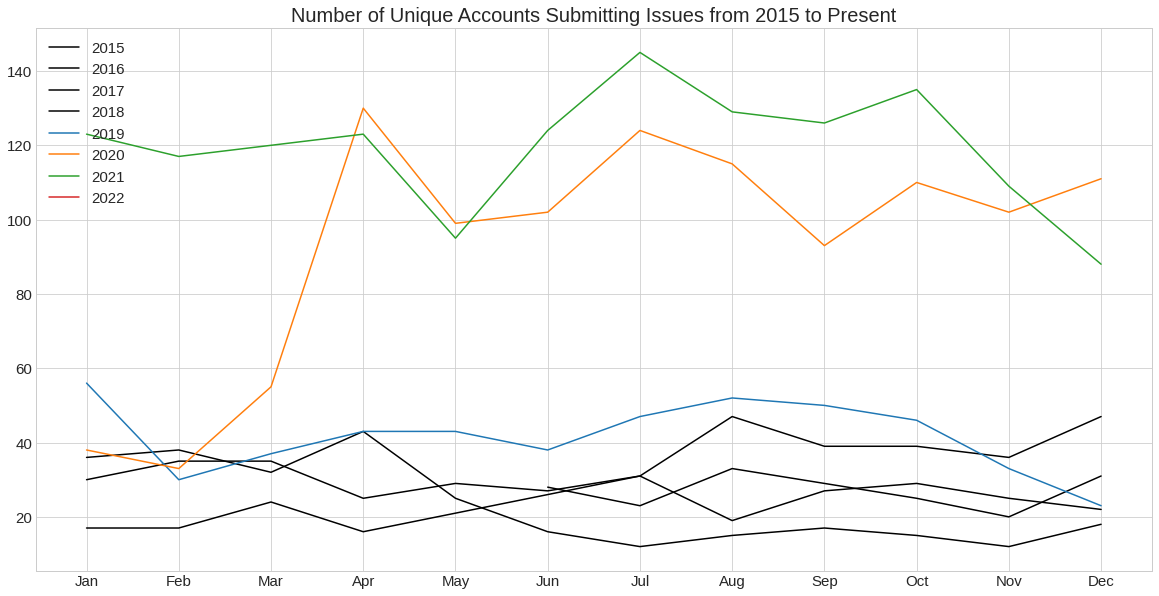

In [221]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))


# plotting for each year, by month
# years prior to, and including, 2019
years = [2015, 2016, 2017, 2018]
i = 0
for year in years:
    sub = monthly_unique[monthly_unique['year'] == year]
    ax.plot(sub['month'], sub['number_of_unique_visitors'], label=year, c='black')
    i += 1


# years of 2019 to present    
years = [2019,2020, 2021, 2022]
i = 0
for year in years:
    sub = monthly_unique[monthly_unique['year'] == year]
    ax.plot(sub['month'], sub['number_of_unique_visitors'], label=year)
    i += 1    
    
# x-axis ticks
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,p:getMonthName(x)))
ax.set_xticks(np.arange(1, 13, 1.0))  

# legend
ax.legend(loc="upper left")

plt.title('Number of Unique Accounts Submitting Issues from 2015 to Present', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.style.use('seaborn-whitegrid')    
plt.show()

Insights:
> The increase in volume of tickets does follow the trend of the increase of unique submitters.


* Number of unique users held steady each year for the 2015 to 2019 period.
* March of 2020, **something** happened to the community - the level of unique users submitting tickets rose sharply, from ~55 to ~130  users for the month of March.
* Since that period, the levels of unique users has continued to be maintained.
* Assumptions as to why the levels rose drastically can be due to COVID, as the pandemic also began March 2020.
> The reasoning behind this spike required further digging. I'd like to look into the number of enterprises utilizing Apache Airflow, as an influx of large corporations could also influence the large spike in activity from community members.

# Part 3c: Length of Time for a Ticket to Close <a class="anchor" id="3c"></a>

[return to TOC](#TOC)

In [222]:
# Create a DF containing open date and number of days closed
df_days = df[['created_date','time_to_close']]

# Remove tickets that have yet to be closed
df_days = df_days[df_days['time_to_close'] != 'Not Closed']

# Changing day values to int
df_days['time_to_close'] = df_days['time_to_close'].astype(int)

In [223]:
df_days

,created_date,time_to_close
0,2022-01-08,0
2,2022-01-08,0
10,2022-01-07,0
14,2022-01-07,0
15,2022-01-07,0
...,...,...
19663,2015-06-05,2
19664,2015-06-05,0
19665,2015-06-05,12
19666,2015-04-20,0


## Outlier Detection

####  Average time for a ticket to close since 2015

In [224]:
df_days.time_to_close.mean()

40.40587606837607

This seams awfully long (over a month for a ticket to close is a very long time). Since we took the mean, let's check the median time.

In [225]:
from statistics import mode

print("The median is", df_days.time_to_close.median())
print("The mode is", mode(df_days.time_to_close))

The median is 1.0
The mode is 0


Median number of days is one and the mode is zero, which implies that most tickets are solved fairly quickly (by the next day). The mean is, therefore, influenced by a number of outliers. Let's find and eliminate them.

### Looking at outliers for the number of days a ticket has been opened for

In [226]:
df_days.time_to_close.value_counts()

0       6644
1       2939
2       1141
3        710
4        532
        ... 
810        1
736        1
203        1
472        1
1733       1
Name: time_to_close, Length: 654, dtype: int64

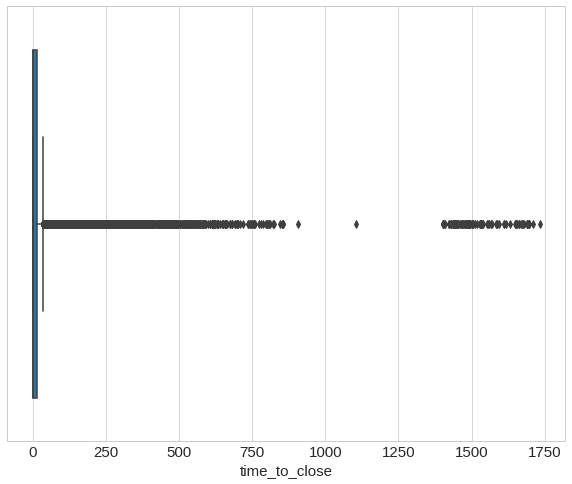

In [227]:
# Box plot to look at the number of days a ticket has been opened for.
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x=df_days.time_to_close)
plt.show()

In [228]:
df_days.time_to_close.describe()

count    18720.000000
mean        40.405876
std        144.314739
min          0.000000
25%          0.000000
50%          1.000000
75%         14.000000
max       1733.000000
Name: time_to_close, dtype: float64

### Removing outliers

In [229]:
drop_numerical_outliers(df_days)

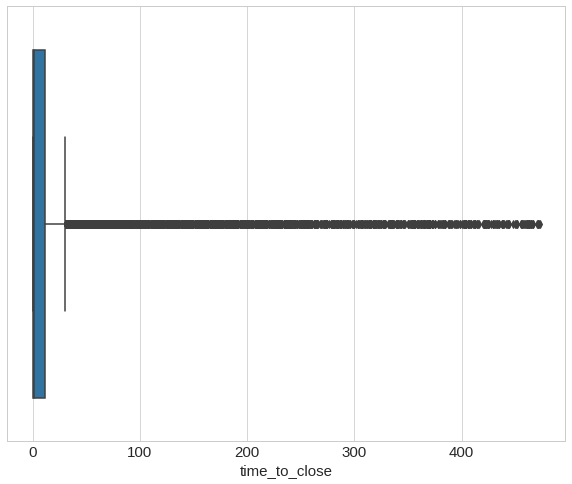

In [230]:
# Box plot to look at the number of days a ticket has been opened for.
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(x=df_days.time_to_close)
plt.show()

In [231]:
df_days.time_to_close.describe()

count    18420.000000
mean        25.650977
std         65.006554
min          0.000000
25%          0.000000
50%          1.000000
75%         12.000000
max        473.000000
Name: time_to_close, dtype: float64

## Analyzing Ticket Completion Time

In [232]:
df_days['year'] = df_days.created_date.apply(lambda x: x.year)
df_days['month'] = df_days.created_date.apply(lambda x: x.month)

In [233]:
monthly_ticket_time = (df_days.groupby([df_days.year, df_days.month])
           .agg(number_of_tickets=('time_to_close', 'size'), average_time_total=('time_to_close', 'mean'))
           .reset_index())


monthly_ticket_time['average_time_total'] = round(monthly_ticket_time['average_time_total'],2)
monthly_ticket_time

,year,month,number_of_tickets,average_time_total
0,2015,4,2,0.00
1,2015,6,95,6.32
2,2015,7,107,10.57
3,2015,8,121,22.46
4,2015,9,132,27.33
...,...,...,...,...
76,2021,9,531,8.02
77,2021,10,501,9.15
78,2021,11,390,5.78
79,2021,12,474,3.46


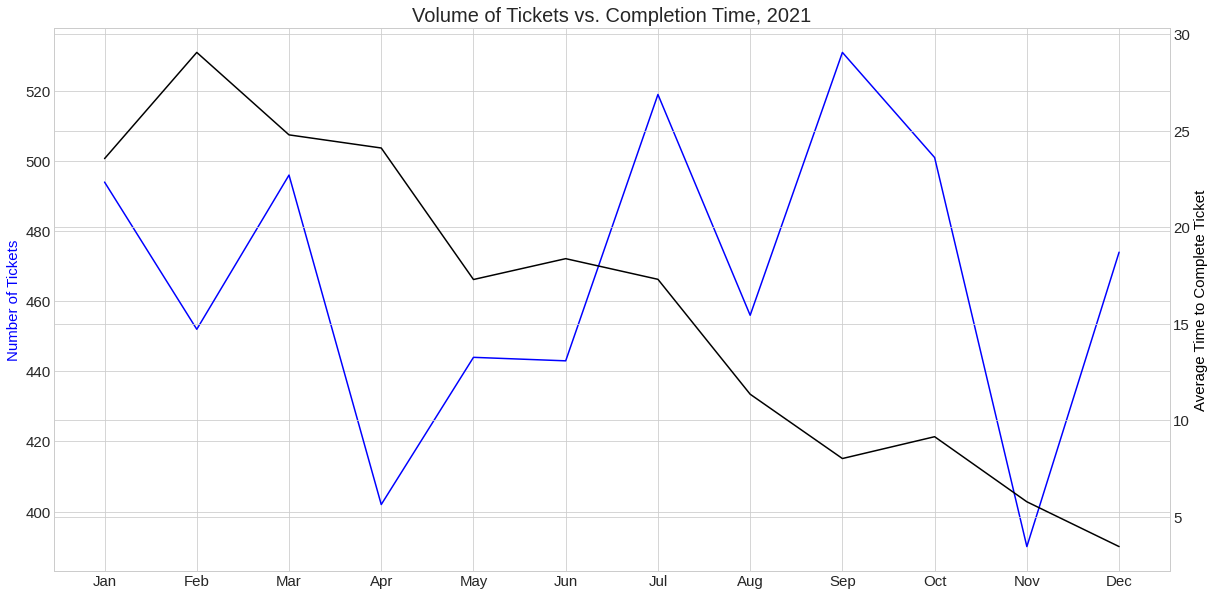

In [234]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))


sub = monthly_ticket_time[monthly_ticket_time['year'] == 2021]
ax.plot(sub['month'], sub['number_of_tickets'], label=2021, c = 'blue')
ax.set_ylabel("Number of Tickets",color="blue",fontsize=15)

ax2=ax.twinx()
sub2 = monthly_ticket_time[monthly_ticket_time['year'] == 2021]
ax2.plot(sub2['month'], sub2['average_time_total'], label=2021, c = 'black')
ax2.set_ylabel("Average Time to Complete Ticket",color="black",fontsize=15)   
    
# x-axis ticks
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,p:getMonthName(x)))
ax.set_xticks(np.arange(1, 13, 1.0))  

plt.title('Volume of Tickets vs. Completion Time, 2021', fontsize=20)
plt.rcParams['font.size'] = '15'
plt.style.use('seaborn-whitegrid')    
plt.show()

* We're able to see an interesting (and positive) trend here: although the volume of tickets held at roughly the same level for 2021, the time it took from ticket creation to completion was on the decline!
> This is good news -- it may imply that community engagement is increasing (quicker response times from members) and documentation/knowledge quality is improving.

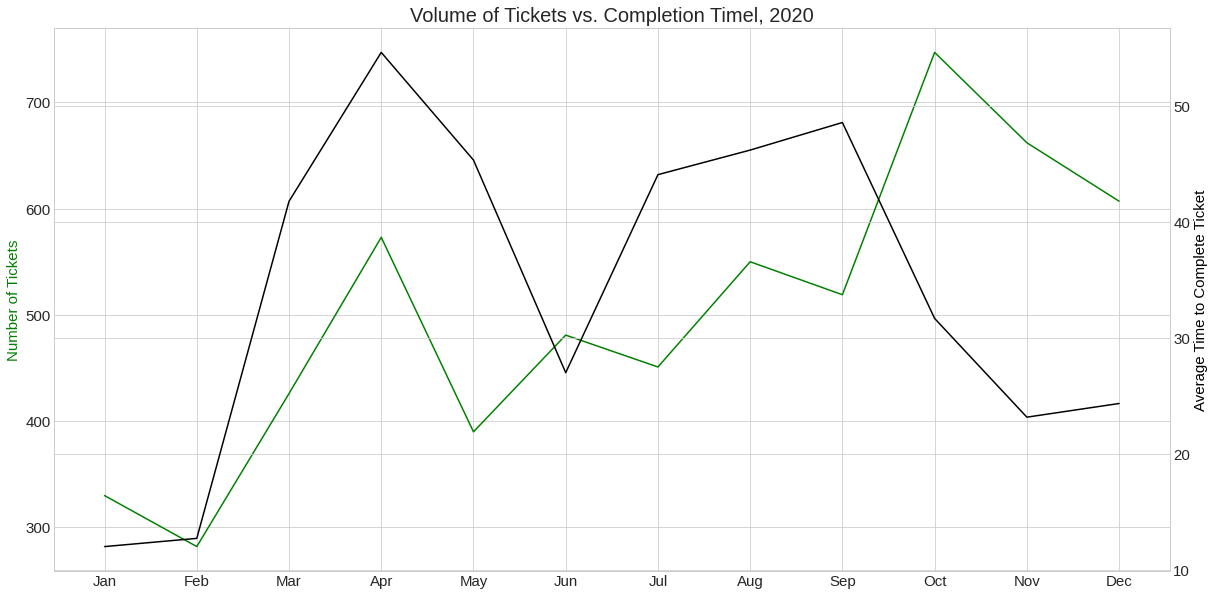

In [235]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))


sub = monthly_ticket_time[monthly_ticket_time['year'] == 2020]
ax.plot(sub['month'], sub['number_of_tickets'], label=2020, c = 'green')
ax.set_ylabel("Number of Tickets",color="green",fontsize=15)

ax2=ax.twinx()
sub2 = monthly_ticket_time[monthly_ticket_time['year'] == 2020]
ax2.plot(sub2['month'], sub2['average_time_total'], label=2020, c = 'black')
ax2.set_ylabel("Average Time to Complete Ticket",color="black",fontsize=15)
    
# x-axis ticks
plt.gca().xaxis.set_major_formatter(mtick.FuncFormatter(lambda x,p:getMonthName(x)))
ax.set_xticks(np.arange(1, 13, 1.0))  

plt.title('Volume of Tickets vs. Completion Timel, 2020', fontsize=20)
plt.rcParams['font.size'] = '15'
plt.style.use('seaborn-whitegrid')    
plt.show()

# Part 3d: Removing Outliers from Numerical Columns with Z-Score Method <a class="anchor" id="3d"></a>

[return to TOC](#TOC)

In [236]:
df_cleaned = df.copy()

In [237]:
drop_numerical_outliers(df_cleaned)

In [238]:
df_cleaned.describe()

,comments,length_of_title,length_of_body,n_labels
count,18886.000000,18886.000000,18886.000000,18886.000000
mean,3.462035,50.322514,1367.132532,1.190088
std,3.674687,16.716960,1144.578102,1.217766
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,39.000000,648.250000,0.000000
50%,2.000000,50.000000,1247.000000,1.000000
75%,5.000000,61.000000,1700.000000,2.000000
max,20.000000,106.000000,9642.000000,5.000000


Distribution before outlier removal:

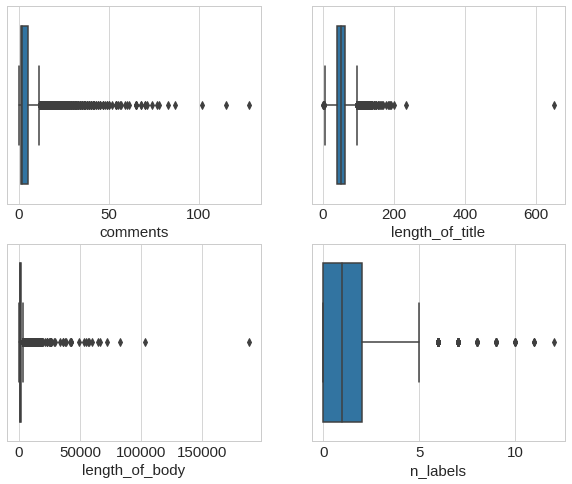

In [239]:
fig, ax = plt.subplots(2,2, figsize=(10,8))

sns.boxplot(ax=ax[0,0], x=df.comments)
sns.boxplot(ax=ax[0,1], x=df.length_of_title)
sns.boxplot(ax=ax[1,0], x=df.length_of_body)
sns.boxplot(ax=ax[1,1], x=df.n_labels)

plt.show()

Distribution **after** outlier removal:

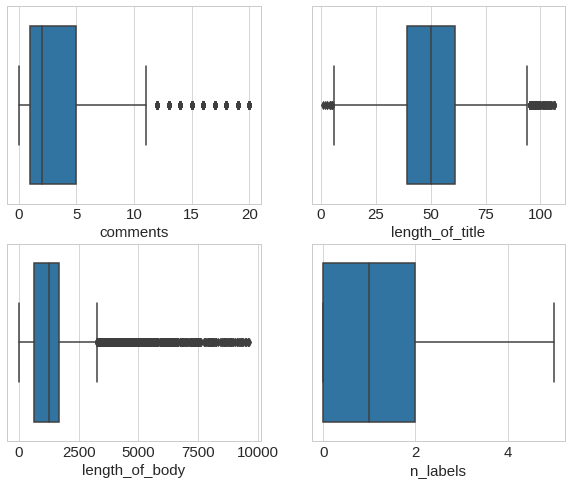

In [240]:
fig, ax = plt.subplots(2,2, figsize=(10,8))

sns.boxplot(ax=ax[0,0], x=df_cleaned.comments)
sns.boxplot(ax=ax[0,1], x=df_cleaned.length_of_title)
sns.boxplot(ax=ax[1,0], x=df_cleaned.length_of_body)
sns.boxplot(ax=ax[1,1], x=df_cleaned.n_labels)

plt.show()

Text(0, 0.5, 'Number of Labels')

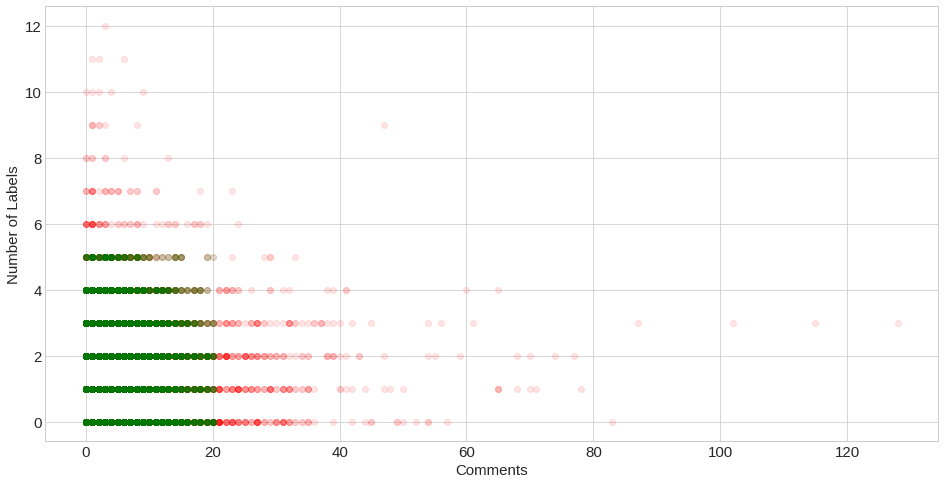

In [241]:
fig, ax = plt.subplots(figsize=(16,8))

x = df_cleaned.comments
y = df_cleaned.n_labels

x2 = df.comments
y2 = df.n_labels

plt.scatter(x2, y2, alpha=0.1, c='red')
plt.scatter(x, y, alpha=0.1, c='green')


plt.xlabel('Comments')
plt.ylabel('Number of Labels')

# Part 4: Machine Learning (Regression to Predict Ticket Resolution Time)<a class="anchor" id="4"></a>

[return to TOC](#TOC)

In [242]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, roc_auc_score


### We will dive into developing a model to help us predict the amount of time a ticket will be resolved based on the information available when the ticket is submitted.

In [243]:
'''
Now that we understand our data better, let's see if we can predict 
whether or not an issue is closed given other attributes.
Should we treat all issues created over the years the same?

We notice that the classes are not balanced. Probably a good idea to address that.

'''

df.state.value_counts()

closed    18720
open        909
Name: state, dtype: int64

### Since we're looking at tickets already closed, we'll remove the ones opened.

In [244]:
df_ml = df_cleaned[df_cleaned['state'] == 'closed']
df_ml.state.value_counts()

closed    18045
Name: state, dtype: int64

In [245]:
# To double check all tickets present are still open, we'll also remove any values labelled Not Closed from the time_to_close column.
df_ml = df_ml[df_ml['time_to_close'] != 'Not Closed']

# Changing day values to type int
df_ml['time_to_close'] = df_ml['time_to_close'].astype(int)

In [246]:
df_ml.state.value_counts()

closed    18045
Name: state, dtype: int64

### Tickets remaining are the ones that are closed.

### Remember the tickets that took hundreds of days to complete and were deemed as outliers earlier? Let's remove those as they aren't within the normal scope of ticket completion times.

In [247]:
# before outlier removal
df_ml.time_to_close.describe()

count    18045.000000
mean        38.465447
std        142.134164
min          0.000000
25%          0.000000
50%          1.000000
75%         12.000000
max       1733.000000
Name: time_to_close, dtype: float64

In [248]:
# Removing outliers for the time_to_close column. Values with a Z-score less than 3 are kept.

u = df_ml.time_to_close.mean()
sd = df_ml.time_to_close.std()

df_ml['outlier'] = df_ml.time_to_close.apply(lambda x: abs((x-u)/sd) < 3)
df_ml = df_ml[df_ml['outlier'] == True]

In [249]:
df_ml.time_to_close.describe()

count    17755.000000
mean        23.838130
std         61.814163
min          0.000000
25%          0.000000
50%          1.000000
75%         11.000000
max        464.000000
Name: time_to_close, dtype: float64

### Let's move onto feature selection

In [250]:
'''
Which of the features above should we include in our ML model?

The title and body are great text features which we could do some NLP on, but maybe later.
'''
def split_features_and_target(df, features_ml=None):
    target = df.time_to_close
    df.drop([c for c in df if c not in features_ml], axis=1, inplace=True)
    return df, target


features_ml, target = split_features_and_target(
    df_ml,
    features_ml = [
        'comments',
        'has_pull_request', 	
        'has_comment', 	
        'has_assignee', 	
        'length_of_title', 	
        'length_of_body', 	
        'n_labels', 	
        'label_area_dev_tools', 	
        'label_area_providers', 	
        'label_area_webserver', 	
        'label_full_tests_needed', 	
        'label_kind_bug', 	
        'label_kind_documentation', 	
        'label_kind_feature', 	
        'label_okay_to_merge', 	
        'label_provider_Google',	
        'frequent_issue_creator',
        'contributor',
        'member',
        'collaborator',
        'not_a_member'
    ]
)

features_ml

,comments,has_pull_request,has_comment,has_assignee,contributor,member,collaborator,not_a_member,length_of_title,length_of_body,n_labels,label_area_dev_tools,label_area_providers,label_area_webserver,label_full_tests_needed,label_kind_bug,label_kind_documentation,label_kind_feature,label_okay_to_merge,label_provider_Google,frequent_issue_creator
0,3,True,True,False,True,False,False,False,27,1266,3,False,True,False,False,False,False,False,True,False,False
2,1,True,True,False,False,True,False,False,54,1072,4,False,True,False,False,False,True,False,True,False,True
10,1,True,True,False,False,True,False,False,57,1129,3,False,True,False,False,False,False,False,True,False,True
14,2,True,True,False,False,False,False,True,28,133,2,False,False,False,False,False,True,False,False,False,False
15,0,True,False,False,True,False,False,False,45,1160,1,True,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19663,3,True,True,False,True,False,False,False,21,282,0,False,False,False,False,False,False,False,False,False,False
19664,3,False,True,False,True,False,False,False,21,401,0,False,False,False,False,False,False,False,False,False,False
19665,17,False,True,False,False,False,False,True,46,203,0,False,False,False,False,False,False,False,False,False,False
19666,0,True,False,False,False,True,False,False,37,0,0,False,False,False,False,False,False,False,False,False,True


In [251]:
target

0         0
2         0
10        0
14        0
15        0
         ..
19663     2
19664     0
19665    12
19666     0
19667     0
Name: time_to_close, Length: 17755, dtype: int64

In [252]:
# Split the data for training and testing
x_train, x_test, y_train, y_test = train_test_split(features_ml, target)

#### Linear Regression

In [253]:
# Linear Regression
lin_reg = LinearRegression().fit(x_train, y_train)

pred_y = lin_reg.predict(x_test)
mse = metrics.mean_squared_error(y_test, pred_y)

print("R2 Train:", lin_reg.score(x_train, y_train))
print("R2 Test:", lin_reg.score(x_test, y_test))
print("MSE:", mse)

R2 Train: 0.19807485928774682
R2 Test: 0.20407542030292458
MSE: 3248.932120535475


#### Gradient Boosting for Regression

In [254]:
from sklearn.ensemble import GradientBoostingRegressor
grad_reg = GradientBoostingRegressor(random_state=0).fit(x_train, y_train)


pred_y = grad_reg.predict(x_test)
mse = metrics.mean_squared_error(y_test, pred_y)
print("R2 Train:", grad_reg.score(x_train, y_train))
print("R2 Test:", grad_reg.score(x_test, y_test))
print("MSE:", mse)

R2 Train: 0.2738783206900609
R2 Test: 0.2254301559423284
MSE: 3161.762948588544


#### Random Forest for Regression

In [255]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=0).fit(x_train, y_train)


pred_y = forest_reg.predict(x_test)
mse = metrics.mean_squared_error(y_test, pred_y)
print("R2 Train:", forest_reg.score(x_train, y_train))
print("R2 Test:", forest_reg.score(x_test, y_test))
print("MSE:", mse)

R2 Train: 0.8828431066044327
R2 Test: 0.1637309183503014
MSE: 3413.6167547639725


The RandomForestRegressor method is actually quite interesting! We have a textbook example of overfitting, where the train data provides us with an R2 of 0.88 and the test that of 0.15.

### ROC

In [256]:
y_pred_lin = lin_reg.predict(x_test)
y_pred_grad = grad_reg.predict(x_test)
y_pred_forest = forest_reg.predict(x_test)

In [257]:
print(y_pred_lin)
print(y_test)

[29.37174822 13.07451339  0.81279647 ... 26.73792249 68.20132815
 60.32621639]
3858       2
16822      1
3483       2
16316      6
4276       0
        ... 
7110       0
18187      0
12245      0
9870      24
15241    249
Name: time_to_close, Length: 4439, dtype: int64


In [258]:
# false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_test, y_score1)


In [259]:
# print('roc_auc_score for Linear Regression: ', roc_auc_score(y_test, y_score1))
# print('roc_auc_score for Gradient Boost Regression: ', roc_auc_score(y_test, y_score2))
# print('roc_auc_score for Random Forest Regression: ', roc_auc_score(y_test, y_score2))
